# Shap Explanation of Pipeline Object: Categorical Features

Data preprocessing is a common step in machine learning. But when we explain a ml model, it is desirable to have the original (vs transformed/preprocessed) feature value in the explanation. This is super easy to accomplish with numerical features ([demo here](https://github.com/MenaWANG/ML_toy_examples/blob/main/explain%20models/shap_num_pipeline.ipynb)). With categorical features where encoding is applied, we need to handle the shape and column name changes of the transformed data. This note shows how it's done with ease. 💃🏻


In [53]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import xgboost as xgb
import shap

# Set up: The dataset

In [54]:
# create data set with numeric features first
n_features = 5
n_informative = 3
X, y = make_classification(n_samples=1000, n_features=n_features, n_informative = n_informative, shuffle=False, random_state = 42)
informative_features_names = [f'inform_{i+1}' for i in range(n_informative)]
random_features_names = [f'random_{i+n_informative+1}' for i in range(n_features - n_informative)]
X = pd.DataFrame(X, columns = informative_features_names + random_features_names)


In [55]:
# add categorical features, cat1 is a moderator, while cat2 is random
cat1 = np.random.choice(['x','y'], size = 1000)
X['inform_1'] = np.where(cat1=='x',X['inform_1'],-X['inform_1']) 
cat2 = np.random.choice(['a','b','c'], size = 1000)
X['cat1'] = cat1
X['cat2'] = cat2


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)
X_train.head()

,inform_1,inform_2,inform_3,random_4,random_5,cat1,cat2
221,1.534134,0.039843,-1.784518,-1.068054,-0.271420,y,a
837,-0.422140,-1.086395,0.359308,0.441261,0.784324,y,c
119,1.597574,-0.638199,0.052157,-0.569312,1.914284,y,a
590,-1.047894,-0.883446,-1.491937,-0.641173,0.273915,x,c
721,-0.243217,-2.112254,-1.317328,-0.053825,0.675367,x,b


# Prepare processing pipeline

In [57]:
num_features = X.select_dtypes(include=np.number).columns
cat_features = X.select_dtypes(exclude=np.number).columns

In [58]:
num_transformer = Pipeline(steps = [
    ("scaler", StandardScaler()),
])

cat_transformer = Pipeline(steps = [
    ("encoder", OneHotEncoder()),
])

column_transformer = ColumnTransformer(transformers = [
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features),
])

model = xgb.XGBClassifier()

pipeline = Pipeline(steps = [
    ('preprocessing', column_transformer),
    ('model', model),
])

In [59]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['inform_1', 'inform_2', 'inform_3', 'random_4', 'random_5'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['cat1', 'cat2'], dtype='object'))])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callb...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

# Use shap to explain the pipeline object

In [60]:
explainer = shap.Explainer(pipeline['model'])
X_test_processed = pipeline['preprocessing'].transform(X_test)
shap_values = explainer(X_test_processed)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [61]:
# the processed X_test have more columns due to OneHotEncoding
print(X_test.shape)
print(X_test_processed.shape)

(200, 7)
(200, 10)


In [62]:
# The original column names
X_test.columns

Index(['inform_1', 'inform_2', 'inform_3', 'random_4', 'random_5', 'cat1',
       'cat2'],
      dtype='object')

In [63]:
# The transformed test data has lost the column name info
try:
    print(X_test_processed.columns)
except Exception as e:
    print('Error:', e)

Error: 'numpy.ndarray' object has no attribute 'columns'


Therefore, the shap explaination also lack the meaningful feature names for us to make sense of the results. 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


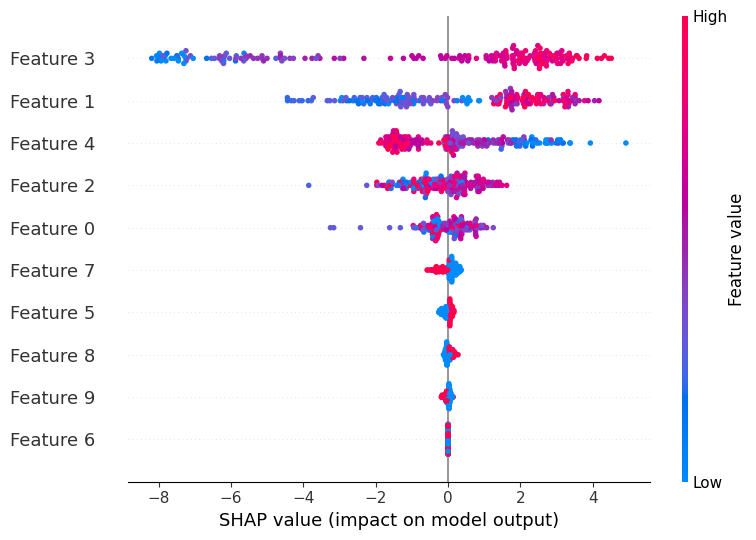

In [64]:
shap.summary_plot(shap_values)

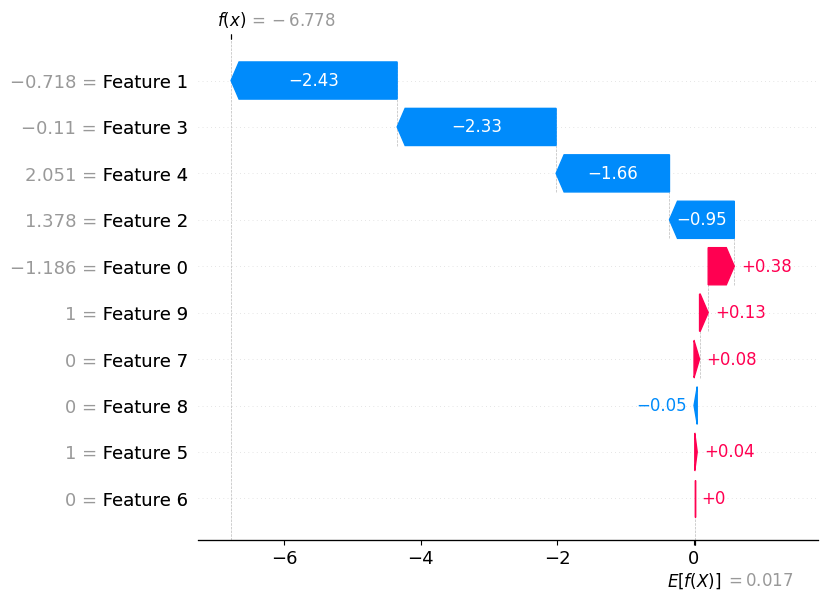

In [65]:
shap.plots.waterfall(shap_values[0])

In [66]:
# The feature names in the above graph doesn't carry much meaning, 
# also the value of the features are not the original either
X_test.iloc[0]

inform_1   -1.431036
inform_2   -1.399182
inform_3    2.240998
random_4    0.121309
random_5    4.273969
cat1               x
cat2               c
Name: 200, dtype: object

# Create meaningful Shap_values.data 

The solution is easy, two things are needed:

1. Assign meaningful column names to the preprocessed test data
2. Assign original values to the numeric to shap explanation

In [67]:
transformed_cols = num_features.tolist()
encoder = pipeline['preprocessing'].named_transformers_['cat']['encoder']
for cat, values in zip(cat_features, encoder.categories_):
    transformed_cols += [f'{cat}_{value}' for value in values]
print(transformed_cols)

['inform_1', 'inform_2', 'inform_3', 'random_4', 'random_5', 'cat1_x', 'cat1_y', 'cat2_a', 'cat2_b', 'cat2_c']


In [68]:
# assign meaningful col names
X_test_processed_df = pd.DataFrame(X_test_processed, columns = transformed_cols)
# switch num features to original values, careful to handle the index beforehand
X_test_processed_df.index = X_test.index
X_test_processed_df[num_features] = X_test[num_features]
shap_values.data = X_test_processed_df

Now when we try explain any individual case, we can see the original feature value as well as meaningful feature names, including for the encoded columns.

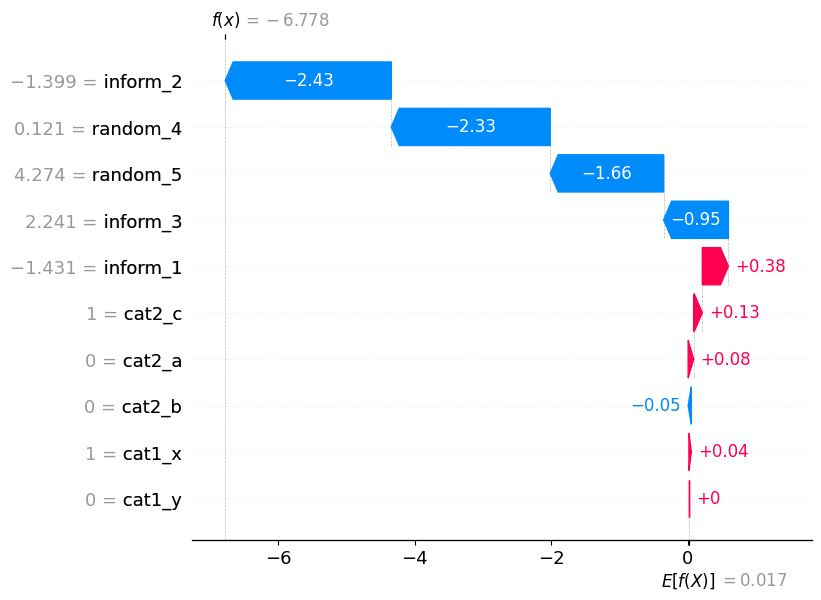

In [69]:

shap.plots.waterfall(shap_values[0])